<a href="https://colab.research.google.com/github/cicattzo/mit_advanced_nlp/blob/main/HW4_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6.864 Homework 4 - Question Answering

#1 Introduction
In this homework, we'll put together all the tools we've learned in this class to build a model for a more complex task: answering questions about written passages.

For this assignment, we'll start with pre-trained sentence representations from a model called DistilBERT (a smaller version of the BERT model we discussed in lecture). See the [paper](https://arxiv.org/pdf/1910.01108.pdf) for more info.

Note that the implementation of this homework for question answering is slightly different from the method introducted in the lecture - in order to let you know more possible solutions to the QA task.



##1.1 Overview
To build a question answering model from DistilBERT, we need to do the following

1. Download a pretrained DistilBERT model.
2. Add a task-specific answer prediction layer on top of DistilBERT's representations.
3. Fine-tune both DistilBERT and the answer prediction layer on a Q&A task.
4. Evaluate the trained Q&A model.

This assignment will also introduce you to a set of libraries from an organization called HuggingFace (yes, really) that are commonly used to access NLP datasets and pre-trained transformer models.



##1.2 Data
The dataset we will be using is the Stanford Question and Answer Dataset (SQuAD) v1.1. You can learn more about the dataset [here](https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/). Just be careful to look at the v1.1 version, not v2. We'll download this model using the HuggingFace `datasets` package.



## 1.3 Pretrained model
You will install the HuggingFace `transformers` package. This package provides a wide variety of pretrained transformers. Check out out the [documentation](https://huggingface.co/transformers/) for more information.


## 1.4 Hardware
Make sure you've enabled GPU as a hardware accelerator for this notebook.


## 1.5 Important: Using Google Drive
It is highly recommended that you mount your Google Drive to Colab. The code provided to you assumes that you've already done that. Create a folder named `6864_hw4` in your Google Drive root directory and use the code below to mount it. The code should save everything (dataset, feature-ized data, trained models etc.) in the `6864_hw4` folder in your drive.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%%bash
# Logistics #2: install the transformers package, create a folder, download the dataset and a patch
pip -q install transformers
pip -q install datasets
pip -q install tqdm
pip -q install sentencepiece 

# remove the directory if necessary
# rm -rf "/content/gdrive/MyDrive/6864_hw4/"

mkdir "/content/gdrive/MyDrive/6864_hw4/"
cd "/content/gdrive/MyDrive/6864_hw4/"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/6864_hw4/’: File exists


Lets load the SQuAD dataset and observe its structure and data

In [3]:
from datasets import load_dataset

squad = load_dataset('squad')
print(squad)

Reusing dataset squad (/root/.cache/huggingface/datasets/squad/plain_text/1.0.0/0fd9e01360d229a22adfe0ab7e2dd2adc6e2b3d6d3db03636a51235947d4c6e9)


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})


In [4]:
for key, value in squad['train'][0].items():
    print(key)
    print(value)
    print('--------------------------')

answers
{'answer_start': [515], 'text': ['Saint Bernadette Soubirous']}
--------------------------
context
Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
--------------------------
id
5733be284776f41900661182
--------------------------
question
To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
--------------------------
title
U

Notice that the `answers` in this dataset always consist of substrings of the `contexts`. Thus, like we discussed in class, we'll build a question-answering model by predicting the _locations_ of answers within contexts.

# 2 Introducing the Huggingface Toolkit

We'll be using two new packages:

- [transformers](https://github.com/huggingface/transformers). In this package,
    - **tokenizers** automatically convert strings into sequence of integer word piece IDs.
    - **models** provided architectures and weights for state-of-the-art pretrained transformer language models.
- [datasets](https://github.com/huggingface/datasets)
    - A toolkit that help you download and and evaluate your model on standard benchmarks easily
    - You can publish your own dataset on Huggingface [Datasets Hub](https://huggingface.co/datasets).

You can find more information and examples with the links above. The [demo notebook](https://drive.google.com/file/d/1_vx14SQkTyeWPW6lRR8_BHAO3urlfaQh/view?usp=sharing) for recitation 6 is also very helpful.



## 2.1 Tokenizers

If we're going to pass text to pretrained models, we need to make sure that the input text is pre-processed into sequences of token IDs in the same way as the training data. `tokenizers`  let us do this:

In [5]:
import transformers

# Use a pretrained tokenizer with CLASS.from_pretrained() function
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-cased')

context = 'You can protect yourself by wearing an N95 mask.'
answer = 'wearing an N95 mask'

context_ids = tokenizer.encode(context)
print(context_ids)
print(tokenizer.convert_ids_to_tokens(context_ids))

[101, 1192, 1169, 3244, 3739, 1118, 3351, 1126, 151, 1580, 1571, 7739, 119, 102]
['[CLS]', 'You', 'can', 'protect', 'yourself', 'by', 'wearing', 'an', 'N', '##9', '##5', 'mask', '.', '[SEP]']


Notice that:

1. the tokenizer has inserted the special tokens `[CLS]` and `[SEP]` to mark the start and end of the sentence
2. the tokenizer has divided the word "N95" into three _word pieces_ `N`, `9` and `5` (refer to the Transformers lecture for a discussion of why we use these kinds of subword units). 

## Task 1: Complete the `ans_loc()` function

To practice working with tokenized text, implement the function below, which identifies the start and end locations of a tokenized phrase within a larger tokenized string. We'll use this function later to identify start and end locations for answers when we train a question answering model.

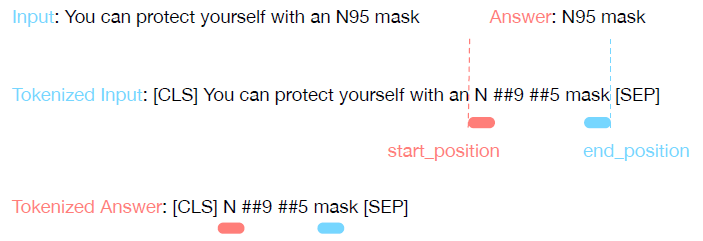

For example, if
- Context = [CLS], protect, yourself, with, an, N, ##9, ##5, mask, [SEP]
- Answer = [CLS], N, ##9, ##5, mask, [SEP]

The the answer location is
- Start postition: 5 (N)
- End postion: 8 (mask)

Hint: you need `ctx_enc['offset_mapping']` to pass all test cases. Refer to this [document](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.__call__) for information about `offset_mapping`. Briefly speaking, offset_mapping is the character-level position of each token in the input text. for the `i`-th token in a input sequence,
```
st_char, ed_char = txt_enc['offset_mapping'][i]
token_id = txt_enc['input_ids'][i]
token_txt = txt_raw[st_char: ed_char]
```

In [42]:
def ans_loc(ctx, ans, verbose=False):

    start_loc = 0
    end_loc = 0
    ctx_enc = tokenizer(ctx, return_offsets_mapping=True, verbose=False)
    ans_enc = tokenizer(ans, return_offsets_mapping=True)

    if verbose:
        print(ctx_enc['input_ids'])
        print(ans_enc['input_ids'])
        print(tokenizer.convert_ids_to_tokens(ctx_enc['input_ids']))
        print(tokenizer.convert_ids_to_tokens(ans_enc['input_ids']))

    # ------------ Your Code Starts ------------- #
    ans_len = len(ans)
    ctx_num_tok = len(ctx_enc['input_ids'])

    ans_first_word = tokenizer.convert_ids_to_tokens(ans_enc['input_ids'])[1]
    ans_first_offset = ans_enc['offset_mapping'][1]
    ans_last_word = tokenizer.convert_ids_to_tokens(ans_enc['input_ids'])[-2]
    ans_last_offset = ans_enc['offset_mapping'][-2]

    # len_offset = 0

    ix = 1
    while start_loc==0 and end_loc==0:
      if tokenizer.convert_ids_to_tokens(ctx_enc['input_ids'])[ix][0:ans_first_offset[1]-ans_first_offset[0]] == tokenizer.convert_ids_to_tokens(ans_enc['input_ids'])[1]:
        start_loc = ix
        word_cts_offset = ctx_enc['offset_mapping'][ix]
        offset_start = word_cts_offset[0]
      if tokenizer.convert_ids_to_tokens(ctx_enc['input_ids'])[ix][0:ans_last_offset[1]-ans_last_offset[0]] == tokenizer.convert_ids_to_tokens(ans_enc['input_ids'])[-2]:
        end_loc = ix
        word_cts_offset = ctx_enc['offset_mapping'][ix]
        offset_end = word_cts_offset[1]
        # len_offset += word_cts_offset[1]-word_cts_offset[0]
      ix+=1

    if end_loc==0:
      if len(ans_enc['input_ids'])==1:
        end_loc = start_loc
      else:
        for ix in range(start_loc+1, ctx_num_tok):
          word_cts_offset = ctx_enc['offset_mapping'][ix]
          if word_cts_offset[1]-offset_start>=ans_len:
            end_loc = ix
            break

    if start_loc==0:
      if len(ans_enc['input_ids'])==1:
        start_loc = end_loc
      else:
        for ix in reversed(range(end_loc)):
          word_cts_offset = ctx_enc['offset_mapping'][ix]
          if offset_end-word_cts_offset[0]>=ans_len:
            start_loc = ix
            break

    
    # ------------ Your Code Ends --------------- #

    return start_loc, end_loc

In [43]:
ctx = "Media files are stored on an iPod in a hidden folder, along with a proprietary database file. The hidden content can be accessed on the host operating system by enabling hidden files to be shown. The media files can then be recovered manually by copying the files or folders off the iPod. Many third-party applications also allow easy copying of media files off of an iPod."
ans = "manual"

ans_loc(ctx, ans, True)

[101, 3957, 7004, 1132, 7905, 1113, 1126, 178, 2101, 5412, 1107, 170, 4610, 22073, 117, 1373, 1114, 170, 18287, 8539, 4956, 119, 1109, 4610, 3438, 1169, 1129, 12269, 1113, 1103, 2989, 3389, 1449, 1118, 12619, 4610, 7004, 1106, 1129, 2602, 119, 1109, 2394, 7004, 1169, 1173, 1129, 6203, 23465, 1118, 5633, 1158, 1103, 7004, 1137, 22073, 1116, 1228, 1103, 178, 2101, 5412, 119, 2408, 1503, 118, 1710, 4683, 1145, 2621, 3123, 5633, 1158, 1104, 2394, 7004, 1228, 1104, 1126, 178, 2101, 5412, 119, 102]
[101, 9506, 102]
['[CLS]', 'Media', 'files', 'are', 'stored', 'on', 'an', 'i', '##P', '##od', 'in', 'a', 'hidden', 'folder', ',', 'along', 'with', 'a', 'proprietary', 'database', 'file', '.', 'The', 'hidden', 'content', 'can', 'be', 'accessed', 'on', 'the', 'host', 'operating', 'system', 'by', 'enabling', 'hidden', 'files', 'to', 'be', 'shown', '.', 'The', 'media', 'files', 'can', 'then', 'be', 'recovered', 'manually', 'by', 'copy', '##ing', 'the', 'files', 'or', 'folder', '##s', 'off', 'the', 'i'

(48, 48)

Test your implementation with the following cases

In [44]:
# -------------- Test Case 1 ----------------- #

print('------------- Test Case 1 -------------')
ctx_c1 = 'You can protect yourself by wearing an N95 mask.'
ans_c1 = 'wearing an N95 mask'

start_loc, end_loc = ans_loc(ctx_c1, ans_c1, verbose=True)
print(f'The start location is {start_loc}, and the end location is {end_loc}')

if (start_loc, end_loc) == (6, 11):
    print('\nYour implementation is correct for case 1')
else:
    print('\nYour implementation failed on case 1')

# -------------- Test Case 2 ----------------- #

print('\n------------- Test Case 2 -------------')
ctx_c2 = 'split with Luckett and Roberson'
ans_c2 = 'Luckett and Rober'

start_loc, end_loc = ans_loc(ctx_c2, ans_c2, verbose=True)
print(f'The start location is {start_loc}, and the end location is {end_loc}')
if (start_loc, end_loc) == (3, 7):
    print('\nYour implementation is correct for case 2')
else:
    print('\nYour implementation failed on case 2')

# -------------- Test Case 3 ----------------- #

print('\n------------- Test Case 3 -------------')
ctx_c2 = 'The UK government has spent £250 million in the construction of the island'
ans_c2 = '250 million'

start_loc, end_loc = ans_loc(ctx_c2, ans_c2, verbose=True)
print(f'The start location is {start_loc}, and the end location is {end_loc}')
if (start_loc, end_loc) == (6, 8):
    print('\nYour implementation is correct for case 3')
else:
    print('\nYour implementation failed on case 3')

------------- Test Case 1 -------------
[101, 1192, 1169, 3244, 3739, 1118, 3351, 1126, 151, 1580, 1571, 7739, 119, 102]
[101, 3351, 1126, 151, 1580, 1571, 7739, 102]
['[CLS]', 'You', 'can', 'protect', 'yourself', 'by', 'wearing', 'an', 'N', '##9', '##5', 'mask', '.', '[SEP]']
['[CLS]', 'wearing', 'an', 'N', '##9', '##5', 'mask', '[SEP]']
The start location is 6, and the end location is 11

Your implementation is correct for case 1

------------- Test Case 2 -------------
[101, 3325, 1114, 22311, 5912, 1105, 6284, 18608, 102]
[101, 22311, 5912, 1105, 6284, 1200, 102]
['[CLS]', 'split', 'with', 'Luck', '##ett', 'and', 'Rob', '##erson', '[SEP]']
['[CLS]', 'Luck', '##ett', 'and', 'Rob', '##er', '[SEP]']
The start location is 3, and the end location is 7

Your implementation is correct for case 2

------------- Test Case 3 -------------
[101, 1109, 1993, 1433, 1144, 2097, 24155, 11049, 1550, 1107, 1103, 2058, 1104, 1103, 2248, 102]
[101, 4805, 1550, 102]
['[CLS]', 'The', 'UK', 'government'

Another useful feature of the tokenizer is the `batch_encode_plus function`, which returns both input IDs and attention masks. For example,



In [45]:
ctx1 = 'I am a short sentence'
ctx2 = 'I am a long long long long long long long sentence'
ctx_list = [ctx1, ctx2]

inputs = tokenizer.batch_encode_plus(
    ctx_list,
    max_length = 12,
    truncation=True,
    padding='longest',
    return_attention_mask=True,
    return_tensors='pt'
)

for key, value in inputs.items():
    print(key)
    print(value)
    print('-------------------------')

input_ids
tensor([[ 101,  146, 1821,  170, 1603, 5650,  102,    0,    0,    0,    0,    0],
        [ 101,  146, 1821,  170, 1263, 1263, 1263, 1263, 1263, 1263, 1263,  102]])
-------------------------
attention_mask
tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
-------------------------


## 2.2 Models

After converting the input texts into ids with corresponding attention masks, we can obtain the hidden state of each word by feeding the input IDs into a Transformer network. We will use the output hidden states to predict the start and end locations of the target answer.

## Sanity Check: Input and Output Shapes of DistilBertModel

Please read the [source code](https://huggingface.co/transformers/_modules/transformers/models/distilbert/modeling_distilbert.html#DistilBertModel) and [document](https://huggingface.co/transformers/model_doc/distilbert.html#transformers.DistilBertModel) of the DistilBertModel class.

Suppose we train a question-answering model based on a DistilBertModel. The batch size of the training inputs is `batch_size`, the maximum sequence length of the input batch is `seq_length`. In other words, the input shape of our model is `[batch_size, seq_length]`. Please answer the following questions to examine if you have understood the class we are going to use,

- What is the shape of the top-layer hidden states?

- According to the [document](https://huggingface.co/transformers/model_doc/distilbert.html#transformers.DistilBertModel) and the `outputs` above, what are potential outputs of the `DistilBertModel`?

If you are not sure if your answers are correct, we encourage you to practice with code to examine your answers.
(No need to include this in your write-up---this is just here to help you debug).




# 3 Building a Question Answering Model

Now that we have access to pre-trained representations, let's start building a question answering model!



## 3.1 Pre-processing the SQuAD data

We preprocess each data point of SQuAD by calculating the start and end positions with the selected tokenizer. In this homework we use the `distilbert-base-cased` model, so we use the `distilbert-base-cased` tokenizer to preprocessing the data. If you want to try other models, please make sure you are using the correct pair of model and tokenizer.



## Task 2: Complete the `proc_line()` function

In [49]:
import json
import random
from multiprocessing import Pool
from tqdm import tqdm, trange

def proc_line_init(tokenizer_for_squad):
    global tokenizer
    tokenizer = tokenizer_for_squad

# Preprocess one SQuAD data point
def proc_line(sq):
    ctx = sq['context']
    ans = sq['answers']['text'][0]
    # print(ctx)
    # print(ans)

    ctx_ids = tokenizer.encode(ctx, verbose=False)
    ans_ids = tokenizer.encode(ans)

    if len(ctx_ids) > 448:
        return None

    start_pos = None
    end_pos = None
    
    # Get the values of start and end pos
    #
    # ----- Your code: get the start and end positions ------ #
    # ----- with the `ans_loc` function you defined --------- #
    
    try:
      start_pos, end_pos = ans_loc(ctx, ans)
    except:
      print('ctx was:', ctx)
      print('ans was:', ans)
    
    # ---------------- End of your code --------------------- #

    sq['start_position'] = start_pos
    sq['end_position'] = end_pos

      # print(ctx)
      # print(ans)
      # print(tokenizer.convert_ids_to_tokens(ans_enc['input_ids'])[start_pos:end_pos])
      # print('\n')

    return sq

# Preprocess SQuAD corpus with tqdm multithreading
def preproc(squad_list, threads, tokenizer):

    with Pool(threads, initializer=proc_line_init, initargs=(tokenizer,)) as p:
        squad_proc = list(tqdm(p.imap(proc_line, squad_list), total=len(squad_list)))

    squad_proc = [x for x in squad_proc if x]
    json.dump(squad_proc, open("/content/gdrive/My Drive/6864_hw4/squad_proc.json", 'w'))
    return squad_proc

squad_list = [x for x in squad['train']]
squad_proc = preproc(squad_list, 16, tokenizer)






  0%|          | 0/87599 [00:00<?, ?it/s]




  0%|          | 6/87599 [00:00<1:18:40, 18.56it/s]




  0%|          | 10/87599 [00:00<1:52:44, 12.95it/s]




  0%|          | 27/87599 [00:01<1:27:44, 16.64it/s]




  0%|          | 62/87599 [00:01<1:04:25, 22.64it/s]




  0%|          | 76/87599 [00:02<1:14:25, 19.60it/s]




  0%|          | 106/87599 [00:02<55:50, 26.12it/s] 




  0%|          | 127/87599 [00:02<44:45, 32.57it/s]




  0%|          | 153/87599 [00:03<45:20, 32.15it/s]




  0%|          | 228/87599 [00:04<35:17, 41.26it/s]




  0%|          | 236/87599 [00:04<32:08, 45.29it/s]




  0%|          | 269/87599 [00:04<26:33, 54.81it/s]




  0%|          | 303/87599 [00:05<21:36, 67.32it/s]




  0%|          | 314/87599 [00:05<25:40, 56.65it/s]




  0%|          | 340/87599 [00:06<29:43, 48.92it/s]




  0%|          | 347/87599 [00:06<44:26, 32.72it/s]




  0%|          | 353/87599 [00:06<55:56, 25.99it/s]




  0%|          | 358/87599 [00:06<48:09, 30.19it

ctx was: Fryderyk may have had some piano instruction from his mother, but his first professional music tutor, from 1816 to 1821, was the Czech pianist Wojciech Żywny. His elder sister Ludwika also took lessons from Żywny, and occasionally played duets with her brother. It quickly became apparent that he was a child prodigy. By the age of seven Fryderyk had begun giving public concerts, and in 1817 he composed two polonaises, in G minor and B-flat major. His next work, a polonaise in A-flat major of 1821, dedicated to Żywny, is his earliest surviving musical manuscript.







  2%|▏         | 1571/87599 [00:22<21:01, 68.18it/s]

ans was: 7
ctx was: Fryderyk may have had some piano instruction from his mother, but his first professional music tutor, from 1816 to 1821, was the Czech pianist Wojciech Żywny. His elder sister Ludwika also took lessons from Żywny, and occasionally played duets with her brother. It quickly became apparent that he was a child prodigy. By the age of seven Fryderyk had begun giving public concerts, and in 1817 he composed two polonaises, in G minor and B-flat major. His next work, a polonaise in A-flat major of 1821, dedicated to Żywny, is his earliest surviving musical manuscript.
ans was: 7
ctx was: Fryderyk may have had some piano instruction from his mother, but his first professional music tutor, from 1816 to 1821, was the Czech pianist Wojciech Żywny. His elder sister Ludwika also took lessons from Żywny, and occasionally played duets with her brother. It quickly became apparent that he was a child prodigy. By the age of seven Fryderyk had begun giving public concerts, and in 1817






  2%|▏         | 1601/87599 [00:23<16:16, 88.06it/s]




  2%|▏         | 1619/87599 [00:23<14:54, 96.11it/s]




  2%|▏         | 1633/87599 [00:23<26:05, 54.91it/s]




  2%|▏         | 1659/87599 [00:23<23:31, 60.90it/s]




  2%|▏         | 1669/87599 [00:24<21:16, 67.34it/s]




  2%|▏         | 1683/87599 [00:24<22:02, 64.97it/s]




  2%|▏         | 1705/87599 [00:24<19:46, 72.37it/s]




  2%|▏         | 1739/87599 [00:24<15:59, 89.45it/s]




  2%|▏         | 1752/87599 [00:25<48:44, 29.36it/s]




  2%|▏         | 1761/87599 [00:25<39:27, 36.26it/s]




  2%|▏         | 1770/87599 [00:27<1:31:48, 15.58it/s]




  2%|▏         | 1812/87599 [00:27<1:07:50, 21.07it/s]




  2%|▏         | 1866/87599 [00:27<48:33, 29.42it/s]  




  2%|▏         | 1884/87599 [00:28<49:46, 28.70it/s]




  2%|▏         | 1897/87599 [00:28<39:52, 35.82it/s]




  2%|▏         | 1974/87599 [00:28<29:22, 48.60it/s]




  2%|▏         | 1991/87599 [00:29<28:36, 49.89it/s]




  2%|▏         | 202

ctx was: The iPod is a line of portable media players and multi-purpose pocket computers designed and marketed by Apple Inc. The first line was released on October 23, 2001, about 8½ months after iTunes (Macintosh version) was released. The most recent iPod redesigns were announced on July 15, 2015. There are three current versions of the iPod: the ultra-compact iPod Shuffle, the compact iPod Nano and the touchscreen iPod Touch.
ans was: 3
ctx was: Before the release of iOS 5, the iPod branding was used for the media player included with the iPhone and iPad, a combination of the Music and Videos apps on the iPod Touch. As of iOS 5, separate apps named "Music" and "Videos" are standardized across all iOS-powered products. While the iPhone and iPad have essentially the same media player capabilities as the iPod line, they are generally treated as separate products. During the middle of 2010, iPhone sales overtook those of the iPod.
ans was: one







  3%|▎         | 2378/87599 [00:35<54:05, 26.25it/s]




  3%|▎         | 2573/87599 [00:35<38:00, 37.28it/s]




  3%|▎         | 2645/87599 [00:36<32:32, 43.51it/s]




  3%|▎         | 2735/87599 [00:36<23:50, 59.32it/s]




  3%|▎         | 2784/87599 [00:37<21:05, 67.00it/s]




  3%|▎         | 2822/87599 [00:37<16:35, 85.19it/s]




  3%|▎         | 2855/87599 [00:38<22:16, 63.41it/s]




  3%|▎         | 2880/87599 [00:38<18:06, 77.94it/s]




  3%|▎         | 2902/87599 [00:40<51:22, 27.48it/s]




  3%|▎         | 2988/87599 [00:41<40:02, 35.21it/s]




  3%|▎         | 3003/87599 [00:41<43:54, 32.11it/s]




  4%|▎         | 3081/87599 [00:41<31:17, 45.02it/s]




  4%|▎         | 3111/87599 [00:41<24:57, 56.44it/s]




  4%|▎         | 3136/87599 [00:42<24:21, 57.79it/s]




  4%|▎         | 3158/87599 [00:42<24:58, 56.34it/s]




  4%|▎         | 3195/87599 [00:42<19:24, 72.46it/s]




  4%|▎         | 3240/87599 [00:43<17:00, 82.66it/s]




  4%|▎         | 3256/8759

ctx was: Raised in Chicago, West briefly attended art school before becoming known as a producer for Roc-A-Fella Records in the early 2000s, producing hit singles for artists such as Jay-Z and Alicia Keys. Intent on pursuing a solo career as a rapper, West released his debut album The College Dropout in 2004 to widespread commercial and critical success, and founded record label GOOD Music. He went on to explore a variety of different musical styles on subsequent albums that included the baroque-inflected Late Registration (2005), the arena-inspired Graduation (2007), and the starkly polarizing 808s & Heartbreak (2008). In 2010, he released his critically acclaimed fifth album, the maximalist My Beautiful Dark Twisted Fantasy, and the following year he collaborated with Jay-Z on the joint LP Watch the Throne (2011). West released his abrasive sixth album, Yeezus, to further critical praise in 2013. Following a series of recording delays and work on non-musical projects, West's seventh 






  7%|▋         | 5920/87599 [01:10<28:33, 47.68it/s]




  7%|▋         | 5963/87599 [01:10<21:25, 63.51it/s]




  7%|▋         | 5978/87599 [01:10<26:05, 52.14it/s]

ctx was: Carrying a Louis Vuitton backpack filled with old disks and demos to the studio and back, West crafted much of his production for his debut album in less than fifteen minutes at a time. He recorded the remainder of the album in Los Angeles while recovering from the car accident. Once he had completed the album, it was leaked months before its release date. However, West decided to use the opportunity to review the album, and The College Dropout was significantly remixed, remastered, and revised before being released. As a result, certain tracks originally destined for the album were subsequently retracted, among them "Keep the Receipt" with Ol' Dirty Bastard and "The Good, the Bad, and the Ugly" with Consequence. West meticulously refined the production, adding string arrangements, gospel choirs, improved drum programming and new verses. West's perfectionism led The College Dropout to have its release postponed three times from its initial date in August 2003.
ans was: 3
ctx w






  7%|▋         | 5993/87599 [01:10<22:48, 59.64it/s]




  7%|▋         | 6004/87599 [01:11<48:37, 27.96it/s]




  7%|▋         | 6057/87599 [01:11<35:50, 37.91it/s]




  7%|▋         | 6072/87599 [01:12<37:22, 36.36it/s]




  7%|▋         | 6082/87599 [01:12<40:30, 33.54it/s]




  7%|▋         | 6090/87599 [01:13<50:48, 26.74it/s]




  7%|▋         | 6119/87599 [01:13<40:54, 33.19it/s]




  7%|▋         | 6126/87599 [01:13<41:45, 32.51it/s]




  7%|▋         | 6172/87599 [01:14<31:15, 43.42it/s]




  7%|▋         | 6217/87599 [01:14<27:22, 49.55it/s]




  7%|▋         | 6227/87599 [01:15<38:42, 35.03it/s]




  7%|▋         | 6285/87599 [01:15<27:56, 48.49it/s]

ctx was: West's first six solo studio albums, all of which have gone platinum, have received numerous awards and critical acclaim. All of his albums have been commercially successful, with Yeezus, his sixth solo album, becoming his fifth consecutive No. 1 album in the U.S. upon release. West has had six songs exceed 3 million in digital sales as of December 2012, with "Gold Digger" selling 3,086,000, "Stronger" selling 4,402,000, "Heartless" selling 3,742,000, "E.T." selling over 4,000,000, "Love Lockdown" selling over 3,000,000, and "Niggas in Paris" selling over 3,000,000, placing him third in overall digital sales of the past decade. He has sold over 30 million digital songs in the United States making him one of the best-selling digital artists of all-time.
ans was: 6
ctx was: West's first six solo studio albums, all of which have gone platinum, have received numerous awards and critical acclaim. All of his albums have been commercially successful, with Yeezus, his sixth solo album






  7%|▋         | 6304/87599 [01:15<36:05, 37.54it/s]




  7%|▋         | 6318/87599 [01:17<1:17:22, 17.51it/s]




  7%|▋         | 6483/87599 [01:17<54:31, 24.79it/s]  




  7%|▋         | 6538/87599 [01:18<39:27, 34.24it/s]




  8%|▊         | 6571/87599 [01:18<34:27, 39.19it/s]




  8%|▊         | 6621/87599 [01:18<25:46, 52.37it/s]




  8%|▊         | 6646/87599 [01:19<27:55, 48.31it/s]




  8%|▊         | 6733/87599 [01:19<20:17, 66.40it/s]




  8%|▊         | 6762/87599 [01:20<19:55, 67.64it/s]




  8%|▊         | 6785/87599 [01:20<21:01, 64.04it/s]




  8%|▊         | 6830/87599 [01:20<16:19, 82.44it/s]




  8%|▊         | 6850/87599 [01:21<17:45, 75.75it/s]

ctx was: For an unprecedented eight consecutive years, from the 2003–04 television season through the 2010–11 season, either its performance or result show had been ranked number one in U.S. television ratings. The popularity of American Idol however declined, and on May 11, 2015, Fox announced that the series would conclude its run in its fifteenth season.
ans was: 15







  8%|▊         | 6939/87599 [01:21<13:57, 96.34it/s]




  8%|▊         | 6991/87599 [01:21<11:25, 117.53it/s]




  8%|▊         | 7012/87599 [01:21<15:30, 86.62it/s] 




  8%|▊         | 7049/87599 [01:22<12:47, 104.97it/s]




  8%|▊         | 7067/87599 [01:23<29:35, 45.35it/s] 




  8%|▊         | 7110/87599 [01:23<22:34, 59.42it/s]




  8%|▊         | 7155/87599 [01:23<16:52, 79.43it/s]




  8%|▊         | 7200/87599 [01:23<13:29, 99.37it/s]




  8%|▊         | 7288/87599 [01:23<09:55, 134.88it/s]




  8%|▊         | 7329/87599 [01:23<09:48, 136.47it/s]




  8%|▊         | 7385/87599 [01:24<07:34, 176.31it/s]




  8%|▊         | 7425/87599 [01:24<09:29, 140.79it/s]

ctx was: Fox announced on May 11, 2015 that the fifteenth season would be the final season of American Idol; as such, the season is expected to have an additional focus on the program's alumni. Ryan Seacrest returns as host, with Harry Connick Jr., Keith Urban, and Jennifer Lopez all returning for their respective third, fourth, and fifth seasons as judges.
ctx was: Fox announced on May 11, 2015 that the fifteenth season would be the final season of American Idol; as such, the season is expected to have an additional focus on the program's alumni. Ryan Seacrest returns as host, with Harry Connick Jr., Keith Urban, and Jennifer Lopez all returning for their respective third, fourth, and fifth seasons as judges.
ans was: 15
ans was: 5







  9%|▊         | 7483/87599 [01:24<08:19, 160.26it/s]




  9%|▊         | 7546/87599 [01:25<07:34, 176.14it/s]




  9%|▊         | 7587/87599 [01:25<08:28, 157.42it/s]

ctx was: The enormous success of the show and the revenue it generated was transformative for Fox Broadcasting Company. American Idol and fellow competing shows Survivor and Who Wants to Be a Millionaire were altogether credited for expanding reality television programming in the United States in the 1990s and 2000s, and Idol became the most watched non-scripted primetime television series for almost a decade, from 2003 to 2012, breaking records on U.S. television (dominated by drama shows and sitcoms in the preceding decades).
ans was: 9







  9%|▊         | 7610/87599 [01:25<09:16, 143.81it/s]

ctx was: The show pushed Fox to become the number one U.S. TV network amongst adults 18–49, the key demographic coveted by advertisers, for an unprecedented eight consecutive years by 2012. Its success also helped lift the ratings of other shows that were scheduled around it such as House and Bones, and Idol, for years, had become Fox's strongest platform primetime television program for promoting eventual hit shows of the 2010s (of the same network) such as Glee and New Girl. The show, its creator Simon Fuller claimed, "saved Fox".
ans was: 8
ctx was: The continuing decline influenced further changes for season 14, including the loss of Coca-Cola as the show's major sponsor, and a decision to only broadcast one, two-hour show per week during the top 12 rounds (with results from the previous week integrated into the performance show, rather than having a separate results show). On May 11, 2015, prior to the fourteenth season finale, Fox announced that the fifteenth season of American I






  9%|▊         | 7630/87599 [01:25<10:32, 126.42it/s]




  9%|▊         | 7647/87599 [01:25<11:41, 113.96it/s]




  9%|▊         | 7662/87599 [01:26<29:37, 44.97it/s] 

ctx was: American Idol was nominated for the Emmy's Outstanding Reality Competition Program for nine years but never won. Director Bruce Gower won a Primetime Emmy Award for Outstanding Directing For A Variety, Music Or Comedy Series in 2009, and the show won a Creative Arts Emmys each in 2007 and 2008, three in 2009, and two in 2011, as well as a Governor's Award in 2007 for its Idol Gives Back edition. It won the People's Choice Award, which honors the popular culture of the previous year as voted by the public, for favorite competition/reality show in 2005, 2006, 2007, 2010, 2011 and 2012. It won the first Critics' Choice Television Award in 2011 for Best Reality Competition.
ans was: 9
ctx was: American Idol was nominated for the Emmy's Outstanding Reality Competition Program for nine years but never won. Director Bruce Gower won a Primetime Emmy Award for Outstanding Directing For A Variety, Music Or Comedy Series in 2009, and the show won a Creative Arts Emmys each in 2007 and 20






  9%|▉         | 7673/87599 [01:26<28:21, 46.97it/s]




  9%|▉         | 7682/87599 [01:27<24:52, 53.53it/s]




  9%|▉         | 7691/87599 [01:27<25:14, 52.75it/s]




  9%|▉         | 7732/87599 [01:27<21:36, 61.59it/s]




  9%|▉         | 7746/87599 [01:27<20:56, 63.56it/s]




  9%|▉         | 7790/87599 [01:27<15:43, 84.60it/s]




  9%|▉         | 7807/87599 [01:28<21:36, 61.52it/s]




  9%|▉         | 7844/87599 [01:28<18:32, 71.69it/s]




  9%|▉         | 7887/87599 [01:28<14:00, 94.84it/s]




  9%|▉         | 7908/87599 [01:28<12:17, 108.06it/s]




  9%|▉         | 7940/87599 [01:29<12:03, 110.05it/s]




  9%|▉         | 7982/87599 [01:29<09:44, 136.27it/s]




  9%|▉         | 8003/87599 [01:29<18:10, 73.01it/s] 




  9%|▉         | 8044/87599 [01:30<15:05, 87.86it/s]




  9%|▉         | 8085/87599 [01:30<12:42, 104.30it/s]




  9%|▉         | 8158/87599 [01:30<09:27, 140.05it/s]




  9%|▉         | 8191/87599 [01:30<11:43, 112.92it/s]




  9%|▉         | 82

ctx was: Focused by the commitment to a Moon landing, in January 1962 the US announced Project Gemini, a two-man spacecraft that would support the later three-man Apollo by developing the key spaceflight technologies of space rendezvous and docking of two craft, flight durations of sufficient length to simulate going to the Moon and back, and extra-vehicular activity to accomplish useful work outside the spacecraft.
ans was: 2







 14%|█▍        | 12137/87599 [02:07<21:45, 57.80it/s]




 14%|█▍        | 12154/87599 [02:07<21:22, 58.85it/s]




 14%|█▍        | 12168/87599 [02:08<21:07, 59.50it/s]




 14%|█▍        | 12242/87599 [02:08<19:01, 65.99it/s]




 14%|█▍        | 12297/87599 [02:09<14:24, 87.13it/s]




 14%|█▍        | 12321/87599 [02:09<12:58, 96.72it/s]




 14%|█▍        | 12375/87599 [02:09<10:50, 115.70it/s]




 14%|█▍        | 12393/87599 [02:09<10:29, 119.46it/s]




 14%|█▍        | 12410/87599 [02:10<16:47, 74.62it/s] 




 14%|█▍        | 12423/87599 [02:10<28:33, 43.86it/s]




 14%|█▍        | 12434/87599 [02:10<25:48, 48.53it/s]




 14%|█▍        | 12562/87599 [02:11<18:25, 67.87it/s]




 14%|█▍        | 12597/87599 [02:11<16:33, 75.47it/s]




 14%|█▍        | 12634/87599 [02:11<13:54, 89.81it/s]




 14%|█▍        | 12659/87599 [02:11<11:53, 105.00it/s]




 15%|█▍        | 12721/87599 [02:11<09:28, 131.61it/s]




 15%|█▍        | 12747/87599 [02:12<11:52, 105.08it/s]




 15

ctx was: On January 13, 1887, the U,S. Government moved to annul the patent issued to Bell on the grounds of fraud and misrepresentation. After a series of decisions and reversals, the Bell company won a decision in the Supreme Court, though a couple of the original claims from the lower court cases were left undecided. By the time that the trial wound its way through nine years of legal battles, the U.S. prosecuting attorney had died and the two Bell patents (No. 174,465 dated March 7, 1876 and No. 186,787 dated January 30, 1877) were no longer in effect, although the presiding judges agreed to continue the proceedings due to the case's importance as a "precedent". With a change in administration and charges of conflict of interest (on both sides) arising from the original trial, the US Attorney General dropped the lawsuit on November 30, 1897 leaving several issues undecided on the merits.
ans was: 9
ctx was: In 1898, Bell experimented with tetrahedral box kites and wings constructed






 16%|█▌        | 13800/87599 [02:21<36:41, 33.52it/s]




 16%|█▌        | 13852/87599 [02:21<28:59, 42.41it/s]




 16%|█▌        | 13874/87599 [02:21<24:25, 50.31it/s]




 16%|█▌        | 13892/87599 [02:22<30:31, 40.24it/s]




 16%|█▌        | 14019/87599 [02:22<21:53, 56.03it/s]




 16%|█▌        | 14046/87599 [02:22<17:10, 71.37it/s]




 16%|█▌        | 14070/87599 [02:23<16:49, 72.85it/s]




 16%|█▌        | 14099/87599 [02:23<15:18, 80.06it/s]




 16%|█▌        | 14116/87599 [02:24<32:00, 38.27it/s]




 16%|█▌        | 14129/87599 [02:24<34:40, 35.31it/s]

ctx was: Saint Helena is one of the most remote islands in the world, has one commercial airport under construction, and travel to the island is by ship only. A large military airfield is located on Ascension Island, with two Friday flights to RAF Brize Norton, England (as from September 2010). These RAF flights offer a limited number of seats to civilians.
ans was: 1







 16%|█▋        | 14318/87599 [02:25<24:30, 49.84it/s]




 16%|█▋        | 14388/87599 [02:25<17:50, 68.40it/s]

ctx was: Education is free and compulsory between the ages of 5 and 16  The island has three primary schools for students of age 4 to 11: Harford, Pilling, and St Paul’s. Prince Andrew School provides secondary education for students aged 11 to 18. At the beginning of the academic year 2009-10, 230 students were enrolled in primary school and 286 in secondary school.







 16%|█▋        | 14442/87599 [02:25<13:12, 92.37it/s]

ans was: 3







 17%|█▋        | 14490/87599 [02:25<11:35, 105.09it/s]

ctx was: Hydrogen gas (dihydrogen or molecular hydrogen) is highly flammable and will burn in air at a very wide range of concentrations between 4% and 75% by volume. The enthalpy of combustion for hydrogen is −286 kJ/mol:
ans was: 286 kJ/mol







 17%|█▋        | 14561/87599 [02:25<08:58, 135.59it/s]




 17%|█▋        | 14601/87599 [02:26<14:07, 86.18it/s] 




 17%|█▋        | 14698/87599 [02:26<10:26, 116.45it/s]




 17%|█▋        | 14738/87599 [02:26<08:54, 136.42it/s]




 17%|█▋        | 14773/87599 [02:27<08:51, 137.04it/s]




 17%|█▋        | 14802/87599 [02:27<10:16, 118.12it/s]




 17%|█▋        | 14825/87599 [02:27<09:17, 130.58it/s]




 17%|█▋        | 14863/87599 [02:28<10:05, 120.06it/s]




 17%|█▋        | 14901/87599 [02:28<11:26, 105.91it/s]




 17%|█▋        | 14916/87599 [02:29<24:15, 49.94it/s] 




 17%|█▋        | 15022/87599 [02:30<20:08, 60.04it/s]




 17%|█▋        | 15126/87599 [02:30<15:12, 79.44it/s]




 17%|█▋        | 15253/87599 [02:30<11:05, 108.68it/s]




 17%|█▋        | 15293/87599 [02:30<08:59, 134.08it/s]




 17%|█▋        | 15327/87599 [02:30<07:39, 157.19it/s]




 18%|█▊        | 15359/87599 [02:31<06:50, 175.99it/s]




 18%|█▊        | 15389/87599 [02:31<12:53, 93.30it/s]

ctx was: In Spain, every person officially has two surnames, one of which is the father's first surname and the other is the mother's first surname. The law contemplates the possibility of joining both surnames with the Catalan conjunction i ("and").
ans was: in







 18%|█▊        | 15794/87599 [02:34<18:18, 65.38it/s]




 18%|█▊        | 16016/87599 [02:34<13:13, 90.26it/s]




 18%|█▊        | 16063/87599 [02:34<10:10, 117.12it/s]




 18%|█▊        | 16108/87599 [02:34<09:44, 122.41it/s]




 18%|█▊        | 16144/87599 [02:35<08:43, 136.45it/s]




 18%|█▊        | 16175/87599 [02:35<07:27, 159.52it/s]




 18%|█▊        | 16204/87599 [02:36<17:25, 68.26it/s] 




 19%|█▊        | 16303/87599 [02:36<12:39, 93.93it/s]




 19%|█▊        | 16341/87599 [02:36<11:27, 103.61it/s]




 19%|█▊        | 16400/87599 [02:36<09:00, 131.65it/s]




 19%|█▉        | 16433/87599 [02:37<09:41, 122.47it/s]




 19%|█▉        | 16487/87599 [02:37<08:15, 143.43it/s]




 19%|█▉        | 16520/87599 [02:37<07:08, 165.95it/s]




 19%|█▉        | 16546/87599 [02:37<11:13, 105.53it/s]




 19%|█▉        | 16580/87599 [02:38<09:20, 126.60it/s]




 19%|█▉        | 16615/87599 [02:38<09:06, 129.97it/s]




 19%|█▉        | 16648/87599 [02:38<07:35, 155.76it/s]

ctx was: In 1353 Bern joined the Swiss Confederacy, becoming one of the eight cantons of the formative period of 1353 to 1481. Bern invaded and conquered Aargau in 1415 and Vaud in 1536, as well as other smaller territories; thereby becoming the largest city-state north of the Alps, by the 18th century comprising most of what is today the canton of Bern and the canton of Vaud.
ans was: 8







 20%|█▉        | 17139/87599 [02:42<13:34, 86.49it/s]




 20%|█▉        | 17162/87599 [02:42<12:20, 95.12it/s]




 20%|█▉        | 17204/87599 [02:42<09:58, 117.65it/s]




 20%|█▉        | 17225/87599 [02:44<32:36, 35.97it/s] 




 20%|█▉        | 17426/87599 [02:45<24:12, 48.30it/s]




 20%|█▉        | 17477/87599 [02:45<19:06, 61.17it/s]




 20%|██        | 17584/87599 [02:45<13:49, 84.38it/s]




 20%|██        | 17619/87599 [02:45<12:27, 93.65it/s]




 20%|██        | 17647/87599 [02:46<14:08, 82.41it/s]




 20%|██        | 17771/87599 [02:46<10:23, 112.03it/s]




 20%|██        | 17818/87599 [02:46<10:21, 112.30it/s]




 20%|██        | 17881/87599 [02:47<08:05, 143.63it/s]




 20%|██        | 17914/87599 [02:47<06:56, 167.15it/s]




 20%|██        | 17945/87599 [02:47<06:52, 168.85it/s]




 21%|██        | 17972/87599 [02:47<07:37, 152.29it/s]




 21%|██        | 17995/87599 [02:48<25:40, 45.17it/s] 




 21%|██        | 18161/87599 [02:49<18:10, 63.65it/s]






ctx was: By the 1950s the success of digital electronic computers had spelled the end for most analog computing machines, but analog computers remain in use in some specialized applications such as education (control systems) and aircraft (slide rule).
ans was: 50s







 27%|██▋       | 23822/87599 [03:34<11:11, 94.94it/s]




 27%|██▋       | 23845/87599 [03:34<09:13, 115.18it/s]




 27%|██▋       | 23871/87599 [03:35<07:57, 133.55it/s]




 27%|██▋       | 23894/87599 [03:35<09:06, 116.58it/s]




 27%|██▋       | 23913/87599 [03:35<10:30, 100.99it/s]




 27%|██▋       | 23940/87599 [03:35<09:41, 109.56it/s]




 27%|██▋       | 24047/87599 [03:35<07:09, 148.11it/s]




 27%|██▋       | 24083/87599 [03:36<08:23, 126.06it/s]




 28%|██▊       | 24111/87599 [03:36<08:04, 131.04it/s]




 28%|██▊       | 24139/87599 [03:36<07:03, 149.73it/s]




 28%|██▊       | 24163/87599 [03:36<07:44, 136.62it/s]




 28%|██▊       | 24216/87599 [03:37<07:28, 141.26it/s]




 28%|██▊       | 24244/87599 [03:37<06:55, 152.47it/s]




 28%|██▊       | 24263/87599 [03:38<22:04, 47.81it/s] 




 28%|██▊       | 24332/87599 [03:38<16:17, 64.70it/s]




 28%|██▊       | 24461/87599 [03:38<11:40, 90.14it/s]




 28%|██▊       | 24509/87599 [03:38<10:34, 99.37it/s]


ctx was: The Latin alphabet of the time still lacked the letters ⟨j⟩ and ⟨w⟩, and there was no ⟨v⟩ as distinct from ⟨u⟩; moreover native Old English spellings did not use ⟨k⟩, ⟨q⟩ or ⟨z⟩. The remaining 20 Latin letters were supplemented by four more: ⟨æ⟩ (æsc, modern ash) and ⟨ð⟩ (ðæt, now called eth or edh), which were modified Latin letters, and thorn ⟨þ⟩ and wynn ⟨ƿ⟩, which are borrowings from the futhorc. A few letter pairs were used as digraphs, representing a single sound. Also used was the Tironian note ⟨⁊⟩ (a character similar to the digit 7) for the conjunction and, and a thorn with a crossbar through the ascender for the pronoun þæt. Macrons over vowels were originally used not to mark long vowels (as in modern editions), but to indicate stress, or as abbreviations for a following m or n.
ans was: ƿ







 33%|███▎      | 28757/87599 [04:26<39:49, 24.63it/s]




 33%|███▎      | 28841/87599 [04:26<28:49, 33.98it/s]




 33%|███▎      | 28886/87599 [04:27<23:30, 41.64it/s]




 33%|███▎      | 28920/87599 [04:27<21:12, 46.11it/s]




 33%|███▎      | 28946/87599 [04:28<23:44, 41.17it/s]




 33%|███▎      | 29006/87599 [04:29<20:09, 48.45it/s]




 33%|███▎      | 29057/87599 [04:29<17:40, 55.20it/s]




 33%|███▎      | 29080/87599 [04:29<15:10, 64.24it/s]




 33%|███▎      | 29093/87599 [04:30<14:46, 66.03it/s]




 33%|███▎      | 29123/87599 [04:30<11:21, 85.75it/s]




 33%|███▎      | 29175/87599 [04:30<11:34, 84.11it/s]




 33%|███▎      | 29215/87599 [04:31<11:56, 81.45it/s]




 33%|███▎      | 29269/87599 [04:31<09:06, 106.76it/s]




 33%|███▎      | 29294/87599 [04:31<10:04, 96.47it/s] 




 33%|███▎      | 29336/87599 [04:31<07:46, 124.95it/s]




 34%|███▎      | 29360/87599 [04:32<08:06, 119.73it/s]




 34%|███▎      | 29380/87599 [04:32<11:36, 83.56it/s] 




 34%

ctx was: In the United States, non-Caucasian LGBT individuals may find themselves in a double minority, where they are neither fully accepted or understood by mainly Caucasian LGBT communities, nor are they accepted by their own ethnic group. Many people experience racism in the dominant LGBT community where racial stereotypes merge with gender stereotypes, such that Asian-American LGBTs are viewed as more passive and feminine, while African-American LGBTs are viewed as more masculine and aggressive. There are a number of culturally specific support networks for LGBT individuals active in the United States. For example, "Ô-Môi" for Vietnamese American queer females.
ans was: Ô-Môi







 39%|███▉      | 34472/87599 [05:37<34:51, 25.41it/s]




 40%|███▉      | 34631/87599 [05:38<25:23, 34.77it/s]




 40%|███▉      | 34749/87599 [05:39<19:46, 44.55it/s]




 40%|███▉      | 34844/87599 [05:39<14:23, 61.13it/s]




 40%|███▉      | 34868/87599 [05:40<20:15, 43.38it/s]




 40%|███▉      | 34886/87599 [05:41<21:01, 41.77it/s]




 40%|███▉      | 34957/87599 [05:41<16:03, 54.61it/s]




 40%|███▉      | 34973/87599 [05:41<14:49, 59.20it/s]




 40%|███▉      | 34986/87599 [05:42<21:32, 40.70it/s]




 40%|███▉      | 34997/87599 [05:43<39:09, 22.39it/s]




 40%|████      | 35079/87599 [05:43<28:28, 30.74it/s]




 40%|████      | 35092/87599 [05:43<24:50, 35.24it/s]




 40%|████      | 35161/87599 [05:44<18:06, 48.28it/s]




 40%|████      | 35179/87599 [05:44<15:37, 55.90it/s]




 40%|████      | 35195/87599 [05:44<17:22, 50.28it/s]




 40%|████      | 35225/87599 [05:44<14:04, 62.03it/s]




 40%|████      | 35252/87599 [05:45<13:30, 64.56it/s]




 40%|████

ctx was: Chinese characters are primarily morphosyllabic, meaning that most Chinese morphemes are monosyllabic and are written with a single character, though in modern Chinese most words are disyllabic and dimorphemic, consisting of two syllables, each of which is a morpheme. In modern Chinese 10% of morphemes only occur as part of a given compound. However, a few morphemes are disyllabic, some of them dating back to Classical Chinese. Excluding foreign loan words, these are typically words for plants and small animals. They are usually written with a pair of phono-semantic compound characters sharing a common radical. Examples are 蝴蝶 húdié "butterfly" and 珊瑚 shānhú "coral". Note that the 蝴 hú of húdié and the 瑚 hú of shānhú have the same phonetic, 胡, but different radicals ("insect" and "jade", respectively). Neither exists as an independent morpheme except as a poetic abbreviation of the disyllabic word.
ans was: 蝴 hú of húdié and the 瑚 hú of shānhú







 60%|██████    | 52653/87599 [09:16<09:28, 61.42it/s]




 60%|██████    | 52688/87599 [09:16<07:12, 80.80it/s]




 60%|██████    | 52717/87599 [09:16<09:01, 64.45it/s]




 60%|██████    | 52733/87599 [09:18<28:06, 20.68it/s]




 60%|██████    | 52917/87599 [09:19<19:40, 29.37it/s]




 60%|██████    | 52972/87599 [09:19<14:14, 40.53it/s]




 61%|██████    | 53021/87599 [09:19<11:56, 48.26it/s]




 61%|██████    | 53058/87599 [09:20<09:13, 62.41it/s]




 61%|██████    | 53090/87599 [09:20<07:29, 76.83it/s]




 61%|██████    | 53118/87599 [09:20<08:40, 66.18it/s]




 61%|██████    | 53141/87599 [09:20<07:26, 77.13it/s]




 61%|██████    | 53160/87599 [09:21<06:25, 89.29it/s]




 61%|██████    | 53186/87599 [09:21<10:11, 56.26it/s]




 61%|██████    | 53268/87599 [09:22<07:43, 74.14it/s]




 61%|██████    | 53286/87599 [09:22<08:09, 70.13it/s]




 61%|██████    | 53302/87599 [09:22<07:02, 81.22it/s]




 61%|██████    | 53339/87599 [09:22<05:28, 104.45it/s]




 61%|███

ctx was: Finally, on 26 June, four days after France sued for an armistice with the Third Reich, the Soviet Union issued an ultimatum demanding Bessarabia and, unexpectedly, Northern Bukovina from Romania. Two days later, the Romanians caved to the Soviet demands and the Soviets occupied the territory. The Hertza region was initially not requested by the USSR but was later occupied by force after the Romanians agreed to the initial Soviet demands. The subsequent waves of deportations began in Bessarabia and Northern Bukovina.
ans was: 6







 61%|██████    | 53479/87599 [09:24<11:34, 49.11it/s]




 61%|██████    | 53526/87599 [09:25<09:59, 56.85it/s]




 61%|██████    | 53536/87599 [09:25<10:44, 52.83it/s]




 61%|██████    | 53554/87599 [09:25<09:31, 59.57it/s]




 61%|██████    | 53589/87599 [09:26<11:45, 48.24it/s]




 61%|██████    | 53606/87599 [09:28<19:11, 29.53it/s]




 61%|██████▏   | 53728/87599 [09:28<14:26, 39.10it/s]




 61%|██████▏   | 53866/87599 [09:29<10:31, 53.39it/s]




 62%|██████▏   | 53883/87599 [09:29<10:22, 54.15it/s]




 62%|██████▏   | 53906/87599 [09:30<10:54, 51.51it/s]




 62%|██████▏   | 53958/87599 [09:30<09:19, 60.12it/s]




 62%|██████▏   | 53990/87599 [09:30<07:15, 77.23it/s]




 62%|██████▏   | 54005/87599 [09:30<07:33, 74.10it/s]




 62%|██████▏   | 54018/87599 [09:31<09:54, 56.51it/s]




 62%|██████▏   | 54067/87599 [09:31<07:36, 73.42it/s]




 62%|██████▏   | 54086/87599 [09:31<06:50, 81.57it/s]




 62%|██████▏   | 54100/87599 [09:31<08:06, 68.88it/s]




 62%|████

ctx was: The permanent snow cover necessary for glacier formation is affected by factors such as the degree of slope on the land, amount of snowfall and the winds. Glaciers can be found in all latitudes except from 20° to 27° north and south of the equator where the presence of the descending limb of the Hadley circulation lowers precipitation so much that with high insolation snow lines reach above 6,500 m (21,330 ft). Between 19˚N and 19˚S, however, precipitation is higher and the mountains above 5,000 m (16,400 ft) usually have permanent snow.
ans was: 19˚N and 19˚S







 62%|██████▏   | 54323/87599 [09:35<17:56, 30.91it/s]




 62%|██████▏   | 54330/87599 [09:35<16:13, 34.19it/s]




 62%|██████▏   | 54432/87599 [09:35<11:35, 47.70it/s]




 62%|██████▏   | 54500/87599 [09:35<08:27, 65.23it/s]




 62%|██████▏   | 54530/87599 [09:36<10:51, 50.79it/s]




 62%|██████▏   | 54594/87599 [09:36<07:55, 69.45it/s]




 62%|██████▏   | 54626/87599 [09:37<06:20, 86.75it/s]




 62%|██████▏   | 54654/87599 [09:37<07:00, 78.36it/s]




 62%|██████▏   | 54675/87599 [09:37<07:17, 75.18it/s]




 62%|██████▏   | 54719/87599 [09:37<05:42, 95.87it/s]




 62%|██████▏   | 54739/87599 [09:38<07:08, 76.70it/s]




 63%|██████▎   | 54755/87599 [09:38<07:50, 69.79it/s]




 63%|██████▎   | 54768/87599 [09:38<09:17, 58.90it/s]




 63%|██████▎   | 54779/87599 [09:39<13:42, 39.89it/s]




 63%|██████▎   | 54812/87599 [09:39<10:50, 50.42it/s]




 63%|██████▎   | 54829/87599 [09:39<10:30, 51.99it/s]




 63%|██████▎   | 54861/87599 [09:40<08:09, 66.95it/s]




 63%|████

ctx was: The term Iran derives directly from Middle Persian Ērān, first attested in a 3rd-century inscription at Rustam Relief, with the accompanying Parthian inscription using the term Aryān, in reference to Iranians. The Middle Iranian ērān and aryān are oblique plural forms of gentilic ēr- (Middle Persian) and ary- (Parthian), both deriving from Proto-Iranian *arya- (meaning "Aryan," i.e., "of the Iranians"), argued to descend from Proto-Indo-European *ar-yo-, meaning "skillful assembler." In Iranian languages, the gentilic is attested as a self-identifier included in ancient inscriptions and the literature of Avesta,[a] and remains also in other Iranian ethnic names such as Alans (Ossetic: Ир – Ir) and Iron (Ossetic: Ирон – Iron).
ans was: Ērān







 91%|█████████ | 79324/87599 [14:29<03:23, 40.76it/s]




 91%|█████████ | 79341/87599 [14:29<02:50, 48.58it/s]




 91%|█████████ | 79409/87599 [14:29<02:06, 64.73it/s]




 91%|█████████ | 79458/87599 [14:30<01:37, 83.36it/s]




 91%|█████████ | 79489/87599 [14:30<01:21, 99.88it/s]




 91%|█████████ | 79509/87599 [14:30<01:09, 116.69it/s]




 91%|█████████ | 79529/87599 [14:30<01:09, 116.82it/s]




 91%|█████████ | 79547/87599 [14:30<01:25, 94.48it/s] 




 91%|█████████ | 79575/87599 [14:30<01:11, 112.30it/s]




 91%|█████████ | 79591/87599 [14:31<01:24, 95.04it/s] 




 91%|█████████ | 79605/87599 [14:31<01:47, 74.08it/s]




 91%|█████████ | 79616/87599 [14:31<02:29, 53.44it/s]




 91%|█████████ | 79625/87599 [14:32<05:11, 25.64it/s]




 91%|█████████ | 79642/87599 [14:33<05:39, 23.41it/s]




 91%|█████████ | 79701/87599 [14:33<04:03, 32.43it/s]




 91%|█████████ | 79771/87599 [14:33<02:54, 44.98it/s]




 91%|█████████ | 79795/87599 [14:34<03:50, 33.82it/s]




 91%

We test the correctness of the preprocessed data by randomly selecting data points.

In [55]:
# Test if your preprocessing is correct
def test_preproc(sq, tokenizer):
    print(sq['context'])
    gt_ans = sq['answers']['text'][0]
    start_pos = sq['start_position']
    end_pos = sq['end_position']

    tok_outputs = tokenizer(sq['context'], return_offsets_mapping=True)
    print(tokenizer.convert_ids_to_tokens(tok_outputs['input_ids']))
    # print(tokenizer.convert_ids_to_tokens(ans_enc['input_ids']))
    ctx_ids = tok_outputs['input_ids']
    offsets = tok_outputs['offset_mapping']

    start_pos_char = offsets[start_pos][0]
    end_pos_char = offsets[end_pos][1]

    pred_ans = sq['context'][start_pos_char: end_pos_char]

    print(f'The annotated answer: {gt_ans} .')
    print(f'The predicted answer: {pred_ans} .')
    if gt_ans == pred_ans:
        print('Pass')
    else:
        print('Something went wrong')

test_preproc(random.choice(squad_proc), tokenizer)

Starting in 1236, the Mongol prince Kublai, who later ruled as Khagan from 1260–1294, was granted a large appanage in North China by his superior, Ögedei Khan. Karma Pakshi, 2nd Karmapa Lama (1203–1283)—the head lama of the Karma Kagyu lineage of Tibetan Buddhism—rejected Kublai's invitation, so instead Kublai invited Drogön Chögyal Phagpa (1235–1280), successor and nephew of Sakya Pandita, who came to his court in 1253. Kublai instituted a unique relationship with the Phagpa lama, which recognized Kublai as a superior sovereign in political affairs and the Phagpa lama as the senior instructor to Kublai in religious affairs. Kublai also made Drogön Chögyal Phagpa the director of the government agency known as the Bureau of Buddhist and Tibetan Affairs and the ruling priest-king of Tibet, which comprised thirteen different states ruled by myriarchies.
['[CLS]', 'Starting', 'in', '123', '##6', ',', 'the', 'Mongol', 'prince', 'Ku', '##bla', '##i', ',', 'who', 'later', 'ruled', 'as', 'K', 

## Task 3: complete the `QuestionAnsweringModel` class

- Read the document of [DistilBERT.forward()]() to understand the inputs and outputs of a Huggingface transformer model, and figure out how to extract representations from the encoder.
- Complete the `forward` function. This function should place logits over start positions and end positions (`log p(start | C, Q)` and `log p(end | C, Q)`), and return the predicted logits. It should also return losses if `start_positions` and `end_positions` are provided.
    - Feed the hidden states into the 1. dropout layer, and 2. linear layer to predict the start and end logits
    - Calculate `start_loss` and `end_loss` with `nn.CrossEntropyLoss` with predicted `start/end_logits` and labeled `start/end_positions` as two seperate classification tasks.
    - Return predicted `start_logits, end_logits` and `total_loss = (start_loss + end_loss) / 2`.

In [64]:
import torch.nn as nn

class ModelOutputs:
    def __init__(self, start_logits=None, end_logits=None, loss=None):
        self.start_logits = start_logits
        self.end_logits = end_logits
        self.loss = loss

class QuestionAnsweringModel(nn.Module):

    def __init__(self, lm=None, dropout=0.2):
        '''
        lm:         a pretrained transformer language model
        dropout:    dropoutrate for the dropout layer
        '''
        super(QuestionAnsweringModel, self).__init__()
        self.qa_outputs = nn.Linear(lm.config.dim, 2)
        self.lm = lm
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input_ids=None, attention_mask=None,
                start_positions=None, end_positions=None):
        '''
        input_ids:          ids of the concatenated input tokens
        attention_mask:     concatenated attention masks (ques+ctx)
        start_positions:    labels of the start positions of the answers
        end_positions:      labels of the end positions of the answers
        '''
        
        lm_output = self.lm(
            # ----- Your code: Model inputs ----- #
            input_ids,
            attention_mask = attention_mask
            # -------- Your code ends ----------- #
        )

        hidden_states = lm_output.last_hidden_state # -- Hidden states of the top transformer layer -- #
        hidden_states = self.dropout(hidden_states)

        start_logits = None
        end_logits = None

        # ----- Get start_logits and end_logits ----------------- #
        #
        # start_logits.size() should be [batch_size, seq_len]
        # end_logits.size() should also be [batch_size, seq_len]
        #
        # ----------------- Your code --------------------------- #

        out = self.qa_outputs(hidden_states)

        start_logits, end_logits = out.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)  # (bs, max_query_len)
        end_logits = end_logits.squeeze(-1)
        
        # -------- End of your code for logits calculation ------ #

        total_loss = None
        if start_positions is not None and end_positions is not None:

            loss_fct = nn.CrossEntropyLoss()
            
            # ----- Getting training losses ------------------- #
            #
            # 1. calculate start_losses with
            #       a. start_logits
            #       b. start_positions
            #
            # 2. calculate end_losses with end_logits
            #       a. end_logits
            #       b. end_positions
            #
            # --------- Your code starts ---------------------- #

            start_loss = loss_fun(start_logits, start_positions)# Your code #
            end_loss = loss_fun(end_logits, end_positions)# Your code #

            # --------- Your code ends ------------------------ #

            total_loss = (start_loss + end_loss) / 2
        
        return ModelOutputs(
            start_logits=start_logits,
            end_logits=end_logits,
            loss=total_loss)

## 3.3 Training the DistilBERT Model

First, we move our model to the GPU. 

In [57]:
# Initialize the QA model and use GPU
lm_pretrained = transformers.AutoModel.from_pretrained('distilbert-base-cased')
model = QuestionAnsweringModel(lm_pretrained)
model = model.cuda()

Then we define the training hyper-parameters, the optimizer, and the learning rate scheduler. Read this [document](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup) to understand how the linear learning rate scheduling influences the learning process.

In [65]:
import torch

# Hyper-parameters: you could try playing with different settings
num_epochs = 1
learning_rate = 3e-5
weight_decay = 1e-5
eps = 1e-6
batch_size = 32
warmup_rate = 0.05
ques_max_length = 64
ctx_max_length = 448

# Calculating the number of warmup steps
num_training_cases = len(squad_proc)
t_total = (num_training_cases // batch_size + 1) * num_epochs
ext_warmup_steps = int(warmup_rate * t_total)

# Initializing an AdamW optimizer
ext_optim = torch.optim.AdamW(model.parameters(), lr=learning_rate,
                              eps=eps, weight_decay=weight_decay)

# Initializing the learning rate scheduler [details are in the BERT paper]
ext_sche = transformers.get_linear_schedule_with_warmup(
    ext_optim, num_warmup_steps=ext_warmup_steps, num_training_steps=t_total
)

print("***** Training Info *****")
print("  Num examples = %d" % t_total)
print("  Num Epochs = %d" % num_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % t_total)

***** Training Info *****
  Num examples = 2729
  Num Epochs = 1
  Batch size = 32
  Total optimization steps = 2729


[link text](https://)We need a function that processes batch data into the input format needed by DistilBERT. We first gather contexts, questions, etc in a batch into their corresponding lists.

In [66]:
def gather_batch(batch):
    ctx_batch  = [x['context'] for x in batch]
    ques_batch = [x['question'] for x in batch]
    ans_batch  = [x['answers']['text'][0] for x in batch]

    start_positions = [x['start_position'] for x in batch]
    end_positions = [x['end_position'] for x in batch]

    return ctx_batch, ques_batch, ans_batch, start_positions, end_positions

and then we encode the texts with the DistilBERT tokenizer, and then process the inputs into the following format:

```
[CLS] <question ids> [SEP] <context ids> [SEP]
```

as you can find out, the inputs of our DistilBERT model is the concatenated question word IDs and context word IDs, marked and seperated by special tokens. Note that besides input IDs, we also need to re-organize the attention masks into the same format. We provide the function for this process, and we encourage you to read the code - should be helpful to your course project and future work.

After we concatenate the context to the question, the start and end positions in the context are off by a constant factor. Please fix start_positions and end_positions below.

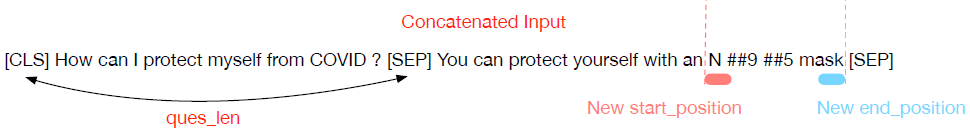



In [67]:
def vectorize_batch(batch, tokenizer):
    ctx_batch, ques_batch, ans_batch, start_positions, end_positions = gather_batch(batch)

    # Encode the context passage
    ctx_encode = tokenizer.batch_encode_plus(
        ctx_batch,
        max_length = ctx_max_length,
        truncation = True,
        padding = 'longest',
        return_attention_mask = True,
        return_tensors = 'pt'
    )

    # Encode the questions
    ques_encode = tokenizer.batch_encode_plus(
        ques_batch,
        max_length = ques_max_length,
        truncation = True,
        padding = 'longest',
        return_attention_mask = True,
        return_tensors = 'pt'
    )

    # Get the actual sequence lengths of question tensors
    ques_seq_len = ques_encode['input_ids'].size(1)

    # Move the training batch to GPU
    ctx_ids        = ctx_encode['input_ids'].cuda()
    ctx_attn_mask  = ctx_encode['attention_mask'].cuda()
    ques_ids       = ques_encode['input_ids'].cuda()
    ques_attn_mask = ques_encode['attention_mask'].cuda()

    # Remove the [CLS] token of the contexts IDs before concatenation
    ctx_ids = ctx_ids[:, 1:]
    ctx_attn_mask = ctx_attn_mask[:, 1:]

    # Concatenate questions and contexts
    input_ids = torch.cat([ques_ids, ctx_ids], dim=1)
    input_attn_mask = torch.cat([ques_attn_mask, ctx_attn_mask], dim=1)

    # Move start and end positions to the GPU
    start_positions = torch.LongTensor(start_positions).cuda()
    end_positions   = torch.LongTensor(end_positions).cuda()

    # update the start_positions and end_positions variables accordingly
    # This is necessary for the following reasons
    # 
    # 1. We concatenated the questions and contexts
    # 2. We removed the [CLS] token (the first token) of the contexts

    start_positions += ques_seq_len - 1
    end_positions += ques_seq_len - 1

    return input_ids, input_attn_mask, start_positions, end_positions

and we can start the training loop, which includes the following steps for processing each mini-batch
- Tokenize questions and contexts, then concatenate the input IDs of questions and corresponding contexts
- Feed the concatenated inputs into the Transformer model
- Optimize the model by back-propagating the loss signals

## Task 4: Complete the code for feeding the inputs to the Transformer model

Hint: Read the implementation of the `forward()` method of the `QuestionAnsweringModel` class to decide the input format.

If you get CUDA out of memory error, do "Manage sessions" -> "TERMINATE" -> "Reconnect" -> Re-run necessary code cells
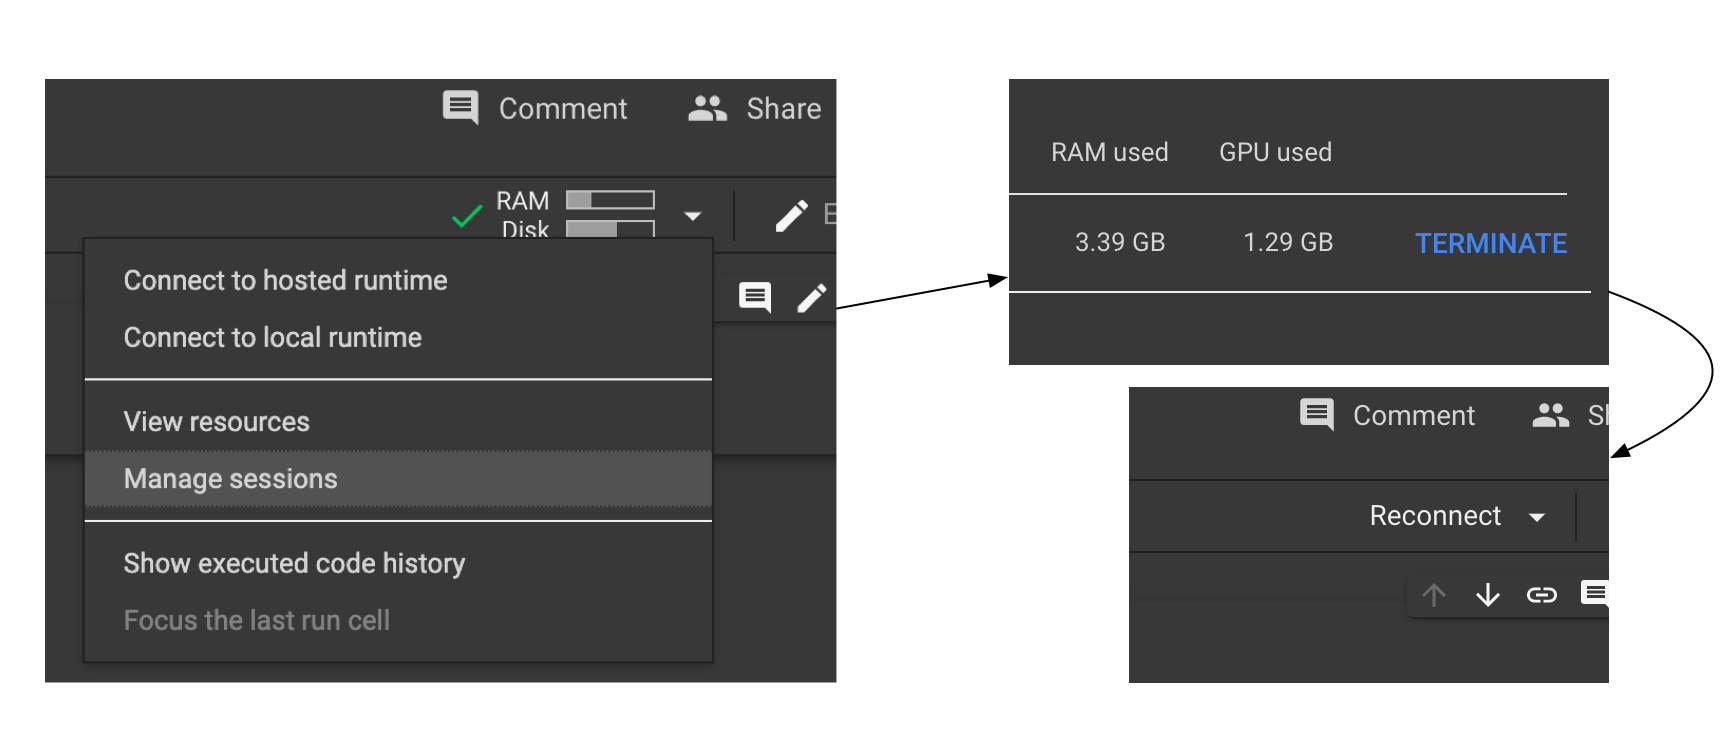

In [68]:
model.train()
max_grad_norm = 1

'''
The training can take up to an hour (~50min in average)
Consider using less training data to validate your implementation
'''
# squad_proc = squad_proc[:10000]
# num_training_cases = len(squad_proc)

step_id = 0
for _ in range(num_epochs):

    random.shuffle(squad_proc)

    for i in range(0, num_training_cases, batch_size):
        batch = squad_proc[i: i + batch_size]
        input_ids, input_attn_mask, start_positions, end_positions = vectorize_batch(batch, tokenizer)

        model.zero_grad() # Does the same as ext_optim.zero_grad()
        
        # Get the model outputs, including (start, end) logits and losses
        # stored as a ModelOutput object
        outputs = model(            
            # --------------------------------------------------- #
            #
            # Read your QuestionAnsweringModel.forward(...)
            # implementation for the input format
            #
            # ------------------ Your code starts --------------- #
            input_ids, 
            input_attn_mask, 
            start_positions, 
            end_positions

            # ------------------ Your code ends ----------------- #
        )

        # Back-propagate the loss signal and clip the gradients
        loss = outputs.loss.mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        # Update neural network parameters and the learning rate
        ext_optim.step()
        ext_sche.step() # Update learning rate for better convergence


        if step_id % 100 == 0:
            print(f'At step {step_id}, the extraction loss = {loss}')
        
        step_id += 1

print('Finished Training')



RuntimeError: ignored

# 4 Evaluating the Learned QA Model

Standard evaluation metrices for extractive, or span-based QA models are exact match (EM) and F1 scores.
- EM: how many predicted answers are exactly the same as the annotated answers
- F1: how many words in the predicted answers overlap the annotated answers.

In other words, the calculations of EM and F1 scores are:
- EM = num_same_answer / num_all_questions
- F1 = (2 * precision * recall) / (precision + recall), where
    - precision = num_overlap_words / num_predicted_answer_words
    - recall = num_overlap_words / num_annotated_answer_words


In [ ]:
def ans_pair_metric(a_pred, a_gt, tokenizer):
    '''
    a_pred: the predicted answer text
    a_gt: the groundtruth answer text
    '''
    
    # Exclude the special tokens
    pred_ids = tokenizer.encode(a_pred)[1: -1]
    gt_ids = tokenizer.encode(a_gt)[1: -1]

    len_pred = len(pred_ids)
    len_gt = len(gt_ids)
    num_same = 0
    for word_id in pred_ids:
        if word_id in gt_ids:
            num_same += 1.
    
    em = float(a_pred == a_gt)
    if num_same == 0:
        f1 = 0
    else:
        prec = num_same / len_pred
        recall = num_same / len_gt
        f1 = 2 * prec * recall / (prec + recall)

    return em, f1

In SQuAD, some context passages are annotated with many possible answers that are considered correct, and we compare our predicted answer with the most similar annotated answer.

In [ ]:
import numpy as np

def one_to_many_metric(a_pred, a_gt_list, tokenizer):
    '''
    a_pred: the predicted answer text
    a_gt_list: the provided ground-truth answer list
    '''
    metric = np.array([ans_pair_metric(a_pred, x, tokenizer) for x in a_gt_list])

    em = metric[:, 0]
    f1 = metric[:, 1]
    return em.max(), f1.max()

We will also need to have a function that infers the locations of answers based on the predicted start and end locations.

## Task 5: complete the `logits_to_ans_loc` function

`logits_to_ans_loc` is a decoding function that converts predicted start and end logits to an actual answer span $(i, j)$, where
- word $w_i$ has a high `start_logit`
- word $w_j$ has a high `end_logit`.

Inputs and outputs
- inputs: `start_logits` and `end_logits`
- outputs
    - st_loc: the index of the start TOKEN (not character) of the predicted answer
    - ed_loc: the index of the end TOKEN of the predicted answer

Note:
- we don't consider answers more than 30 tokens
- Make sure `ed_loc >= st_loc`
- Higher start/end logits stands for higher probability that a word could be the start/end point of an answer
- Please implement three strategies for getting answer span $(i, j)$
    - `greedy_left_to_right` - Select $i = argmax_i \ S_{start}^i$, then select $j = argmax_j \ S_{end}^j$. ($i \le j$)
    - `greedy_right_to_lett` - Select $j = argmax_j \ S_{end}^j$, then select $i = argmax_i \ S_{start}^i$ ($i \le j$)
    - `joint` - Select $(i, j)$ by $$i, j = argmax_{i, j} \ S_{start}^i + S_{end}^j \ (i \le j) $$ 
    - Compare the performance

In [ ]:
def logits_to_ans_loc(start_logits, end_logits, mode='joint'):
    '''

    Input sizes -
        start_logits.size() = [batch_size, seq_len]
        end_logits.size() = [batch_size, seq_len]

    Output sizes -
        st_loc.size() = (batch_size,)
        ed_loc.size() = (batch_size,)

    '''
    bs, seq_len = start_logits.size()

    st_loc = None
    ed_loc = None
    
    # Find the span (i, j) that could be an answer
    # to the question, based on the predicted
    # start_logits and end_logits with three modes
    #   - greedy_left_to_right
    #   - greedy_right_to_left
    #   - joint
    #
    # ------------ Your code starts -------------- #

    # tensor( [[0, 1, ..., seq_len - 1]] )
    # pos_idx.size() = (1, seq_len)
    pos_idx = torch.range(0, seq_len - 1).cuda().unsqueeze(0)
    
    if mode == 'greedy_left_to_right':
        # Your code #

    if mode == 'greedy_right_to_left':
        # Your code #

    if mode == 'joint':
        # Your code #


    # ------------ Your code ends ---------------- #
    
    return st_loc, ed_loc

and now we start implementing the evaluation loop

## Task 6: complete the evaluation loop

In [ ]:
model.eval()

# Prepare the dev set of SQuAD for evaluation
dev_set = [x for x in squad['validation']]
num_dev_cases = len(dev_set)

eval_batch_size = 64

# `ans_pred_list` stores the predicted answers
# in the same order as the contexts of the dev set
ans_pred_list_ltr = []
ans_pred_list_rtl = []
ans_pred_list_joint = []
ans_gt_list = [x['answers']['text'] for x in dev_set]

for i in range(0, num_dev_cases, eval_batch_size):
    eval_batch = dev_set[i: i + eval_batch_size]
    ques = [x['question'] for x in eval_batch]
    ctx  = [x['context'] for x in eval_batch]

    # Encode the contexts
    ctx_encode = tokenizer.batch_encode_plus(
        ctx,
        max_length = ctx_max_length,
        truncation = True,
        padding = 'longest',
        return_attention_mask = True,
        return_tensors = 'pt',
        return_offsets_mapping = True
    )

    # Encode the questions
    ques_encode = tokenizer.batch_encode_plus(
        ques,
        max_length = ques_max_length,
        truncation = True,
        padding = 'longest',
        return_attention_mask = True,
        return_tensors = 'pt'
    )

    # get the actual question sequence lengths
    ques_len = ques_encode['input_ids'].size(1)

    # ------------- Your code Part 1 -------------- #
    #
    # concatenate the input ids and attention masks
    # of questions and contexts. Refer to the training
    # loop for implementation hints
    #
    # --------------------------------------------- #
    
    input_ids = torch.cat(
        [], # what tensors to concatenate
        dim = # on which dimension?
    ).cuda()

    input_attn_mask = torch.cat(
        [], # what tensors to concatenate
        dim = # on which dimension?
    ).cuda()

    # ------------- Your code Part 1 ends ---------- #

    with torch.no_grad():
        outputs = model(
            input_ids,
            attention_mask = input_attn_mask,
        )
    
    # ------------- Your code Part 2 --------------- #
    #
    # Obtain the predicted start and end logits
    # We drop the start and end logits of question tokens
    # and only keep the logits of
    #
    #       [SEP] or [PAD], ctx_1, ctx_2, ..., [SEP]
    #
    # keep the first special token, which is the tail
    # or padding token of the tokenized question, to
    # help you do later decoding more easily 
    #
    # ---------------------------------------------- # 
    
    start_logits_pred = # Your code #
    end_logits_pred = # Your code #

    # ------------- Your code Part 2 ends ---------- #

    st_locs_ltr, ed_locs_ltr = logits_to_ans_loc(
        start_logits_pred, end_logits_pred, mode='greedy_left_to_right'
    )

    st_locs_rtl, ed_locs_rtl = logits_to_ans_loc(
        start_logits_pred, end_logits_pred, mode='greedy_right_to_left'
    )
    
    st_locs_joint, ed_locs_joint = logits_to_ans_loc(
        start_logits_pred, end_logits_pred, mode='joint'
    )

    num_pred_answer = st_locs_ltr.size(0)

    # ---------------------------------------------- #
    #
    # Store predicted answer texts in `ans_pred_list`
    # 1. `ans_pred_list` should look like
    #             ['ans_txt_1', 'ans_txt_2', ....]
    #
    # 2. `len(ans_pred_list)` should equas to
    #             `len(dev_set)`
    #
    # ---------------------------------------------- #
    
    for j in range(num_pred_answer):
        st_char_ltr = ctx_encode['offset_mapping'][j][st_locs_ltr[j]][0]
        ed_char_ltr = ctx_encode['offset_mapping'][j][ed_locs_ltr[j]][1]
        ans_pred_list_ltr.append(ctx[j][st_char_ltr: ed_char_ltr])

        st_char_rtl = ctx_encode['offset_mapping'][j][st_locs_rtl[j]][0]
        ed_char_rtl = ctx_encode['offset_mapping'][j][ed_locs_rtl[j]][1]
        ans_pred_list_rtl.append(ctx[j][st_char_rtl: ed_char_rtl])

        st_char_joint = ctx_encode['offset_mapping'][j][st_locs_joint[j]][0]
        ed_char_joint = ctx_encode['offset_mapping'][j][ed_locs_joint[j]][1]
        ans_pred_list_joint.append(ctx[j][st_char_joint: ed_char_joint])
    
    # ---------------------------------------------- #

# Print the evaluation results
#
# The performance is decided by both training quality
# AND the implementation of the `logits_to_anc_loc` function

# Target result
# - EM: 67.97%
# - F1: 80.89%

print('Evaluating greedy_left_to_right strategy')
metric = np.array([one_to_many_metric(x, y, tokenizer) for x, y in zip(ans_pred_list_ltr, ans_gt_list)])
em = metric[:, 0].mean()
f1 = metric[:, 1].mean()

print(f'EM = {em}')
print(f'F1 = {f1}')

# Target result
# - EM: 67.97%
# - F1: 80.89%

print('\nEvaluating greedy_right_to_left strategy')
metric = np.array([one_to_many_metric(x, y, tokenizer) for x, y in zip(ans_pred_list_rtl, ans_gt_list)])
em = metric[:, 0].mean()
f1 = metric[:, 1].mean()

print(f'EM = {em}')
print(f'F1 = {f1}')

# Target result
# - EM: 68.99%
# - F1: 81.77%

print('\nEvaluating joint strategy')
metric = np.array([one_to_many_metric(x, y, tokenizer) for x, y in zip(ans_pred_list_joint, ans_gt_list)])
em = metric[:, 0].mean()
f1 = metric[:, 1].mean()

print(f'EM = {em}')
print(f'F1 = {f1}')